# Forecasting with Dynamic Linear Model (DLM)
- https://pyro.ai/examples/forecasting_dlm.html

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam
from pyro.ops.stats import quantile

pyro.enable_validation(True)
pyro.set_rng_seed(20200928)

pd.set_option('display.max_rows', 500)
plt.style.use('fivethirtyeight')

In [2]:
torch.manual_seed(20200101)
# number of predictors, total observations
p = 5
n = 365 * 3

# start, train end, test end
T0 = 0
T1 = n - 28
T2 = n

# initializing coefficients at zeros, simulate all coefficient values
beta0 = torch.empty(n, 1).normal_(0, 0.1).cumsum(0)
betas_p = torch.empty(n, p).normal_(0, 0.02).cumsum(0)
betas = torch.cat([beta0, betas_p], dim=-1)

# simulate regressors
covariates = torch.cat(
    [torch.ones(n, 1), torch.randn(n, p) * 0.1],
    dim=-1
)

# observation with noise
y = ((covariates * betas).sum(-1) + 0.1 * torch.randn(n)).unsqueeze(-1)

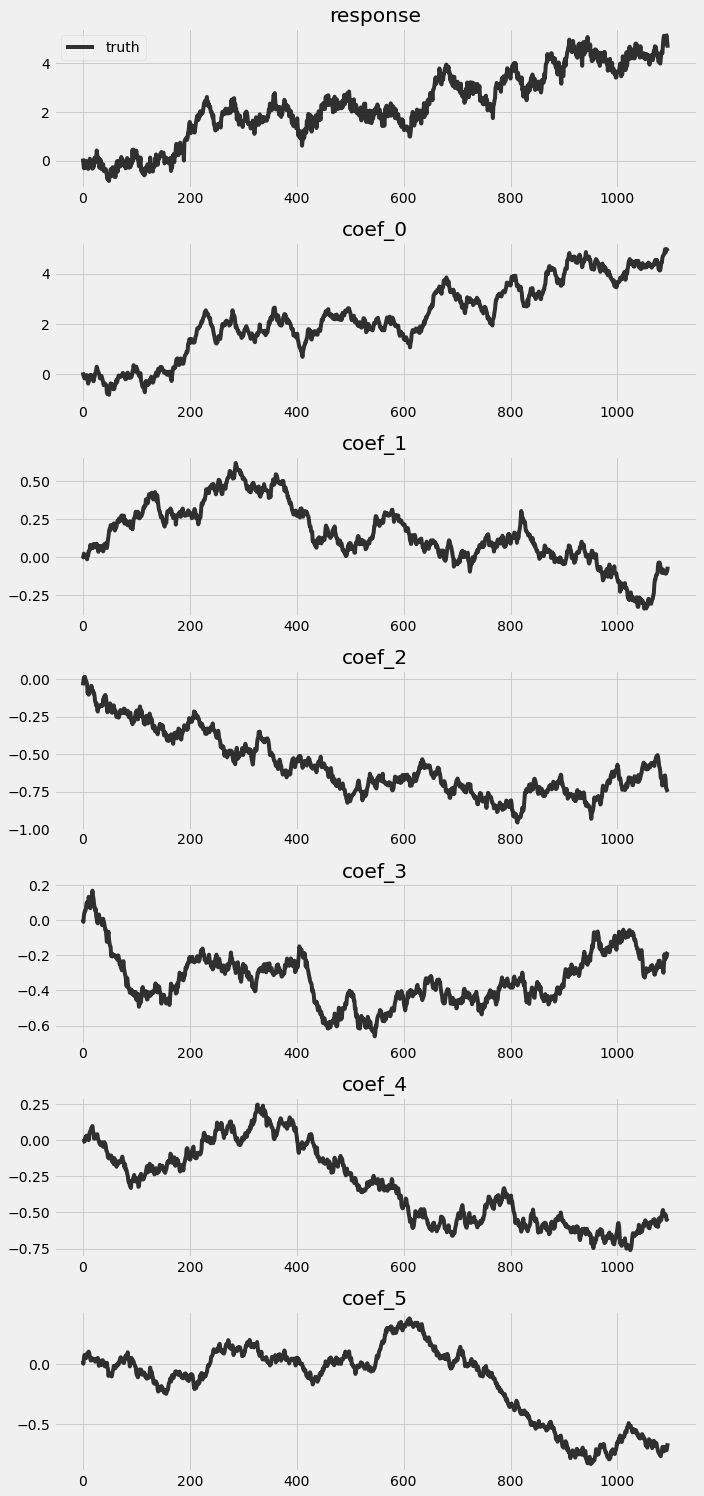

In [3]:
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))
for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y, 'k-', label='truth', alpha=.8)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:, idx -  1], 'k-', label='truth', alpha=.8)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

In [30]:
class DLM(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))

        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace
        pyro.deterministic("weight", weight)
        
        prediction = (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)

        self.predict(noise_dist, prediction)

In [31]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = DLM()
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

INFO 	 step    0 loss = 7.11372e+10
INFO 	 step  100 loss = 175.808
INFO 	 step  200 loss = 2.03577
INFO 	 step  300 loss = 1.19896
INFO 	 step  400 loss = 1.25964
INFO 	 step  500 loss = 2.96454
INFO 	 step  600 loss = 0.803448
INFO 	 step  700 loss = 1.0845
INFO 	 step  800 loss = 0.949263
INFO 	 step  900 loss = 0.991001


CPU times: user 8.5 s, sys: 167 ms, total: 8.67 s
Wall time: 8.62 s


In [6]:
pyro.set_rng_seed(1)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates[:T1], num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

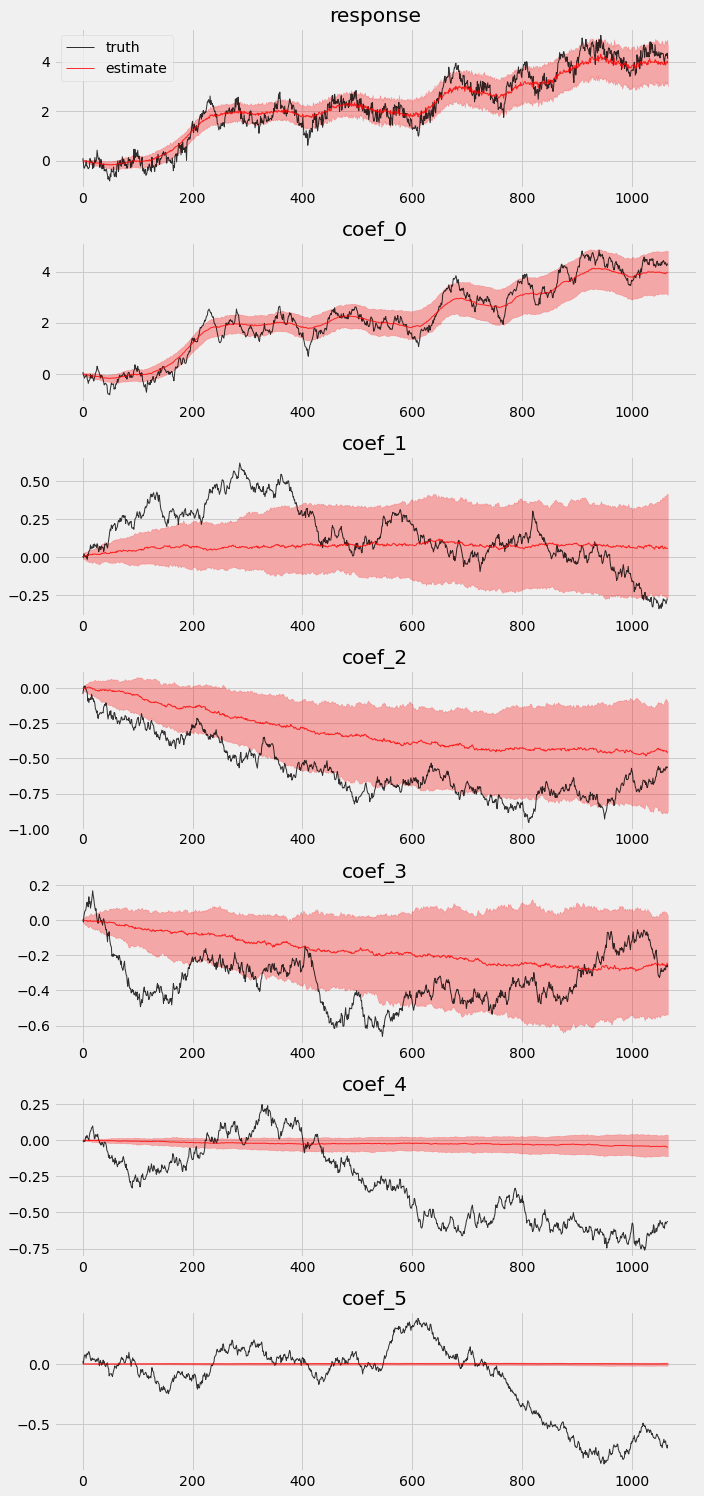

In [7]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))
# posterior quantiles of latent variables
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
# posterior quantiles of latent variables
coef_p10, coef_p50, coef_p90 = quantile(posterior_samples['weight'], (0.1, 0.5, 0.9)).squeeze(-1)

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8, lw=1)
        axes[0].plot(pred_p50, 'r-', label='estimate', alpha=.8, lw=1)
        axes[0].fill_between(torch.arange(0, T1), pred_p10, pred_p90, color="red", alpha=.3)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx -  1], 'k-', label='truth', alpha=.8, lw=1)
        axes[idx].plot(coef_p50[:, idx - 1], 'r-', label='estimate', alpha=.8, lw=1)
        axes[idx].fill_between(torch.arange(0, T1), coef_p10[:, idx-1], coef_p90[:, idx-1], color="red", alpha=.3)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

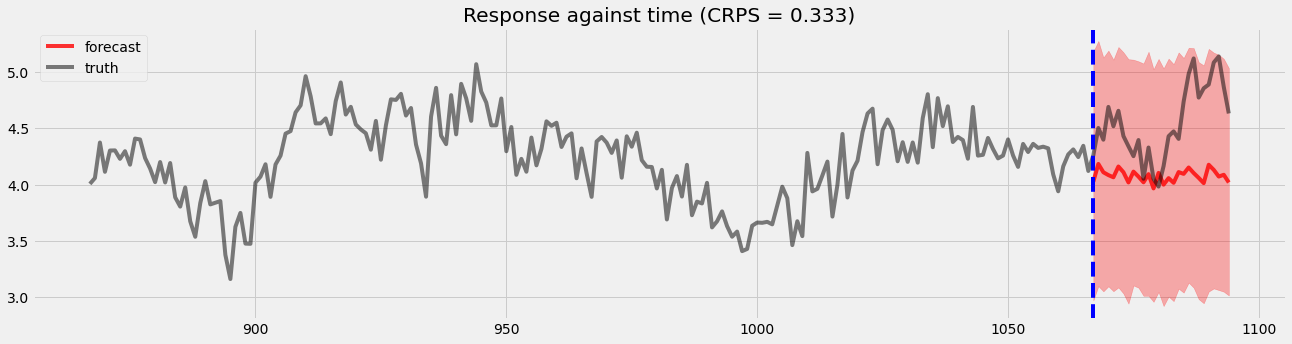

In [8]:
pyro.set_rng_seed(1)
samples = forecaster(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, y[T1:])

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(np.arange(T1 - 200, T2), y[T1 - 200:T2], 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");

In [9]:
# let's provide some priors
time_points = np.concatenate((
    np.arange(300, 320),
    np.arange(600, 620),
    np.arange(900, 920),
))
# broadcast on time-points
priors = betas[time_points, 1:]
print(time_points.shape, priors.shape)

(60,) torch.Size([60, 5])


In [ ]:
class DLM2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-10, 10).expand([feature_dim]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(torch.zeros(covariates.size()), drift_scale).to_event(1))
        weight = drift.cumsum(-2)  # A Brownian motion.
        # record in model_trace
        pyro.deterministic("weight", weight)

        # This is the only change from the simpler DLM model.
        # We inject prior terms as if they were likelihoods using pyro observe statements.
        for tp, prior in zip(time_points, priors):
            pyro.sample("weight_prior_{}".format(tp), dist.Normal(prior, 0.5).to_event(1), obs=weight[..., tp:tp+1, 1:])

        prediction = (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
        # record in model_trace
        pyro.deterministic("prediction", prediction)

        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 10).expand([1]).to_event(1))
        noise_dist = dist.Normal(0, scale)
        self.predict(noise_dist, prediction)

In [ ]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = DLM2()
forecaster2 = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

In [ ]:
pyro.set_rng_seed(1)
with poutine.trace() as tr:
    forecaster2(y[:T1], covariates[:T1], num_samples=100)

posterior_samples2 = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

In [ ]:
# overlay estimations with truth
fig, axes = plt.subplots(p + 2, 1, figsize=(10, 3 * (p + 2)))
# posterior quantiles of latent variables
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples2['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)
# posterior quantiles of latent variables
coef_p10, coef_p50, coef_p90 = quantile(posterior_samples2['weight'], (0.1, 0.5, 0.9)).squeeze(-1)

for idx, ax in enumerate(axes):
    if idx == 0:
        axes[0].plot(y[:T1], 'k-', label='truth', alpha=.8, lw=1)
        axes[0].plot(pred_p50, 'r-', label='estimate', alpha=.8, lw=1)
        axes[0].fill_between(torch.arange(0, T1), pred_p10, pred_p90, color="red", alpha=.3)
        axes[0].legend()
        axes[0].set_title('response')
    else:
        axes[idx].plot(betas[:T1, idx - 1], 'k-', label='truth', alpha=.8, lw=1)
        axes[idx].plot(coef_p50[:, idx - 1], 'r-', label='estimate', alpha=.8, lw=1)
        if idx >= 2:
            axes[idx].plot(time_points, priors[:, idx-2], 'o', color='blue', alpha=.8, lw=1)
        axes[idx].fill_between(torch.arange(0, T1), coef_p10[:, idx-1], coef_p90[:, idx-1], color="red", alpha=.3)
        axes[idx].set_title('coef_{}'.format(idx - 1))
plt.tight_layout()

In [ ]:
pyro.set_rng_seed(1)
samples2 = forecaster2(y[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples2, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples2, y[T1:])
print(samples2.shape, p10.shape)

plt.figure(figsize=(20, 5))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast', alpha=.8)
plt.plot(np.arange(T1 - 200, T2), y[T1 - 200:T2], 'k-', label='truth', alpha=.5)
plt.title("Response against time (CRPS = {:0.3g})".format(crps))
plt.axvline(T1, color='b', linestyle='--')
plt.legend(loc="best");